# 1. Dependencies: pyaudio libraries and Facebook's detectron2

In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

# need to restart runtime to make the changes effective 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html


## 1.1 pyaudio libraries

In [ ]:
import pyaudio
import wave
import struct

## 1.2 the detectron libraries

In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu111 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# 2. Prepare the model 

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_1x.yaml")
predictor = DefaultPredictor(cfg)


model_final_04e291.pkl: 237MB [00:08, 28.2MB/s]                           


# 3. Using a mp4 file as example video input 

In [ ]:
def monitorVideoStream(predictor, input_video_file = 'example_video.mp4'):

    # create a VideoCapture object and read from input file
    # pass 0 to use the camera as input
    cap = cv2.VideoCapture(input_video_file)

    if (cap.isOpened()== False): 
      print("Error opening video stream or file")

    detected_imgs = 0

    # read video frame one by one
    while(cap.isOpened()):
      
      ret, frame = cap.read()
      if ret == True:

        # do object detection on the input video frame
        outputs = predictor(frame)
        v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2_imshow(out.get_image()[:, :, ::-1])

        detected_imgs += 1

        # it's impossible to press 'q' in google colab, just after a few frame
        if cv2.waitKey(25) & 0xFF == ord('q') or detected_imgs == 10:
          # can't quit automatically in Colab, just manually end after a few images
          break

      # Break the loop
      else: 
        break

    # When everything done, release the video capture object
    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()

# 4. Main program:  

sus


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


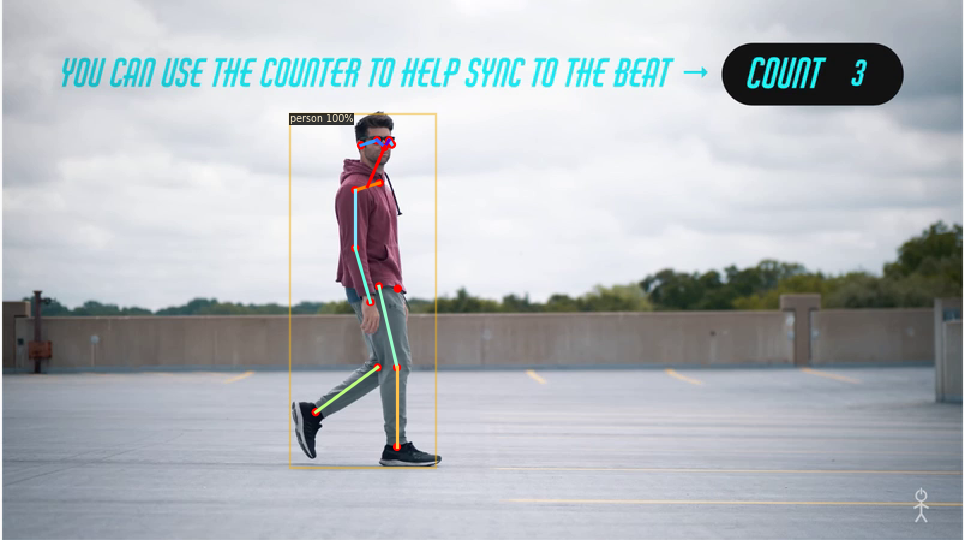

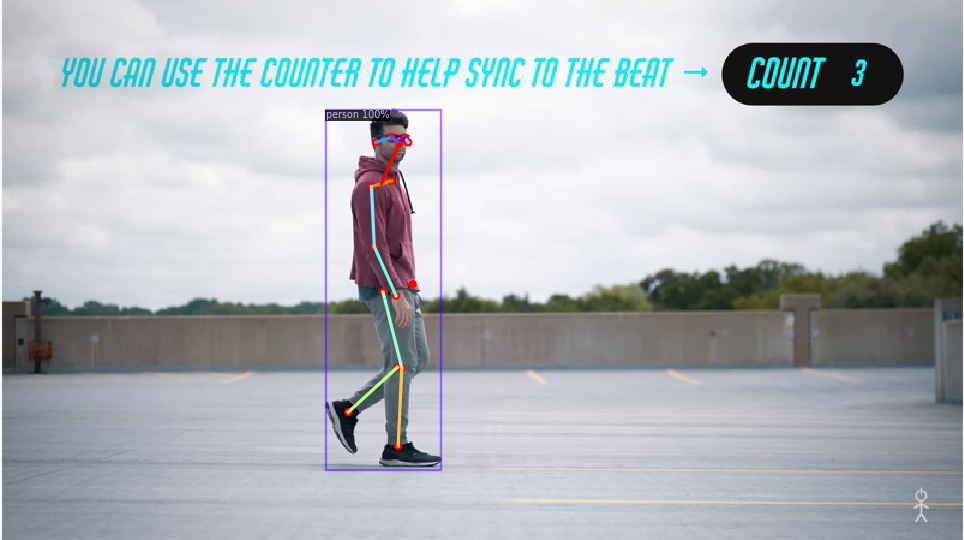

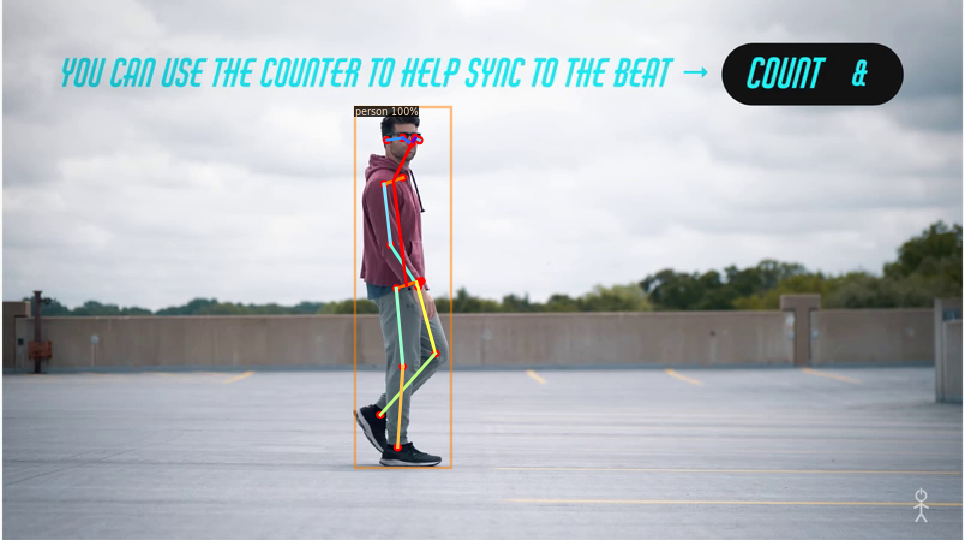

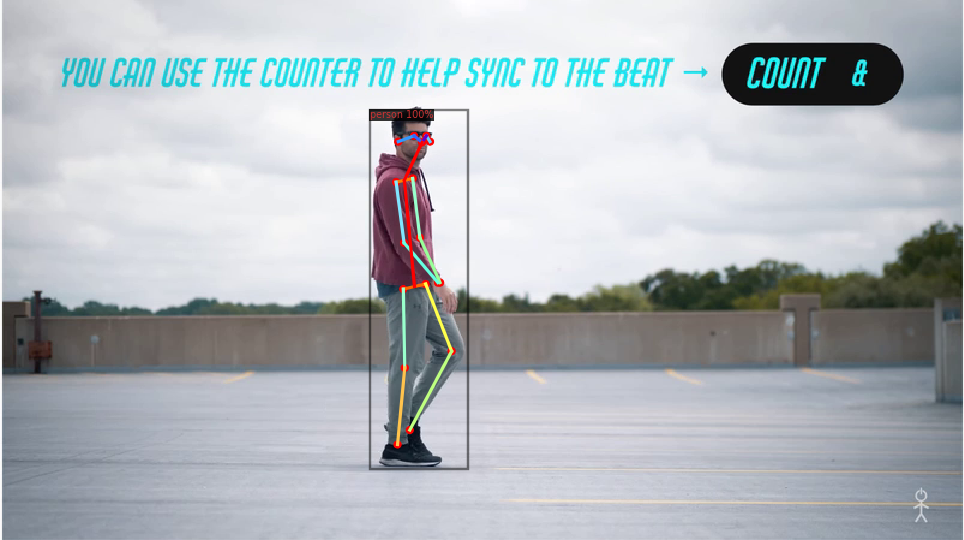

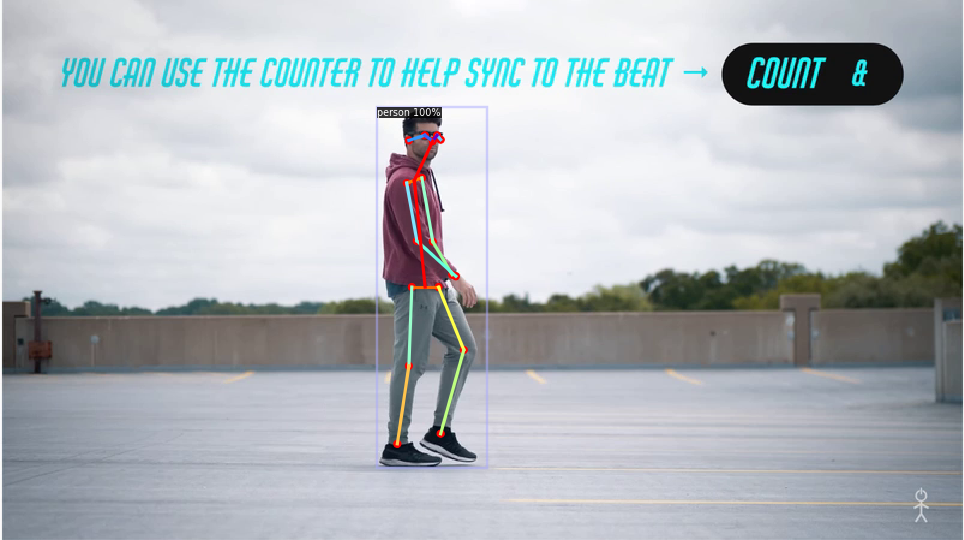

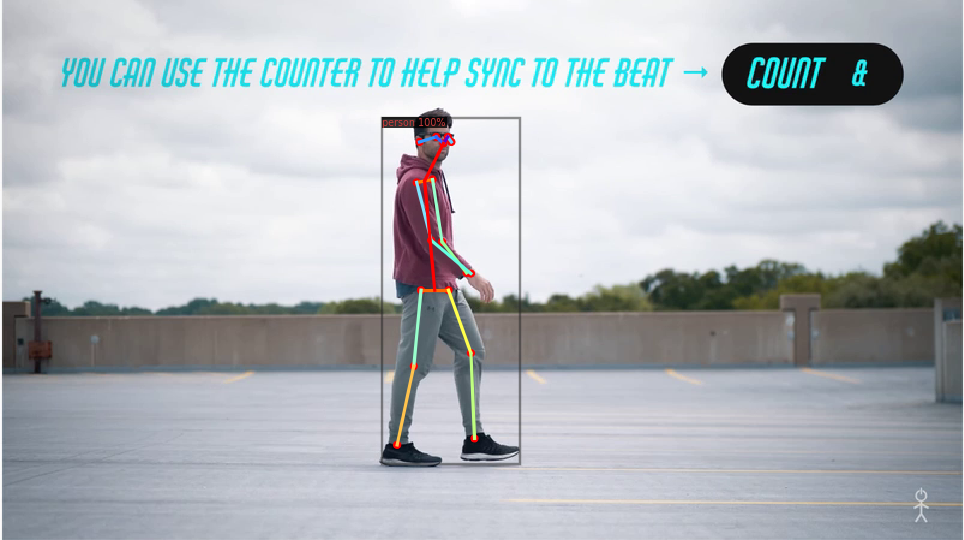

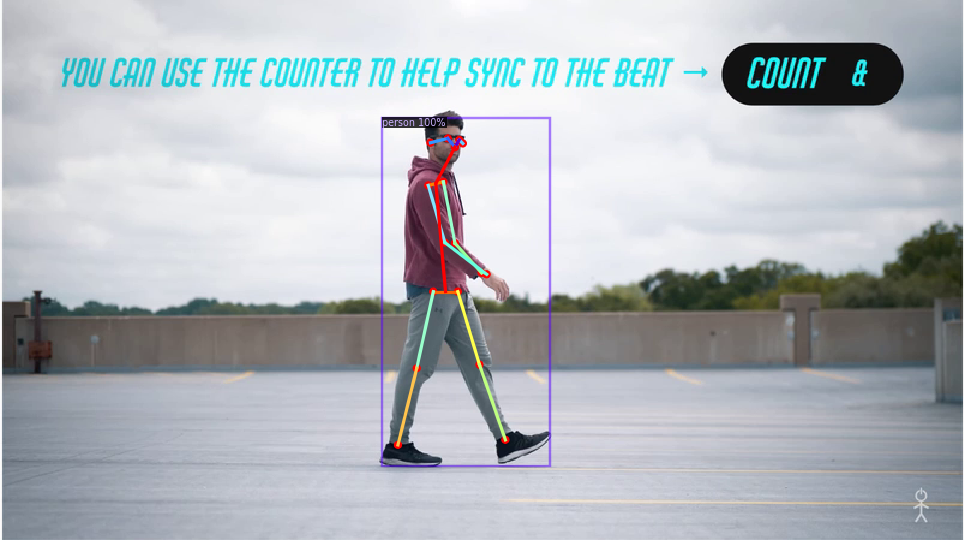

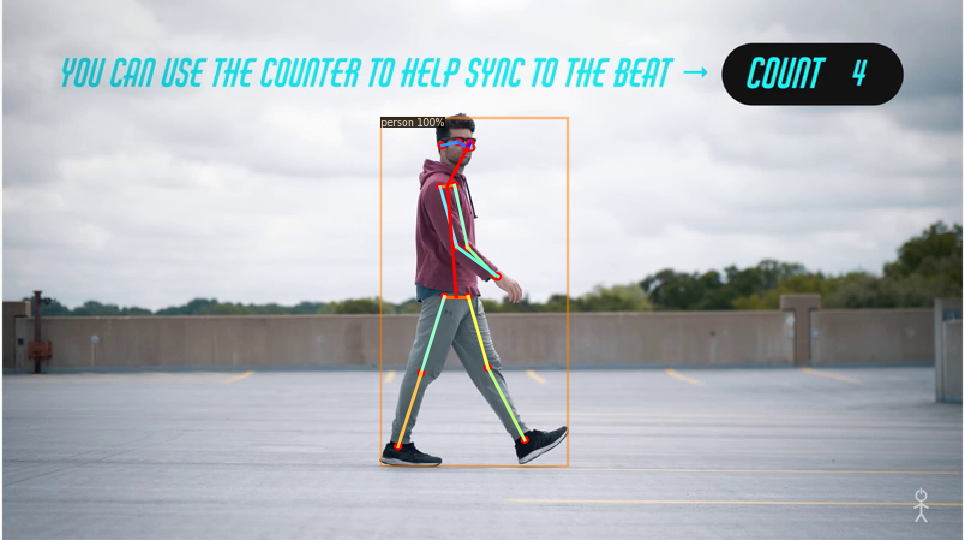

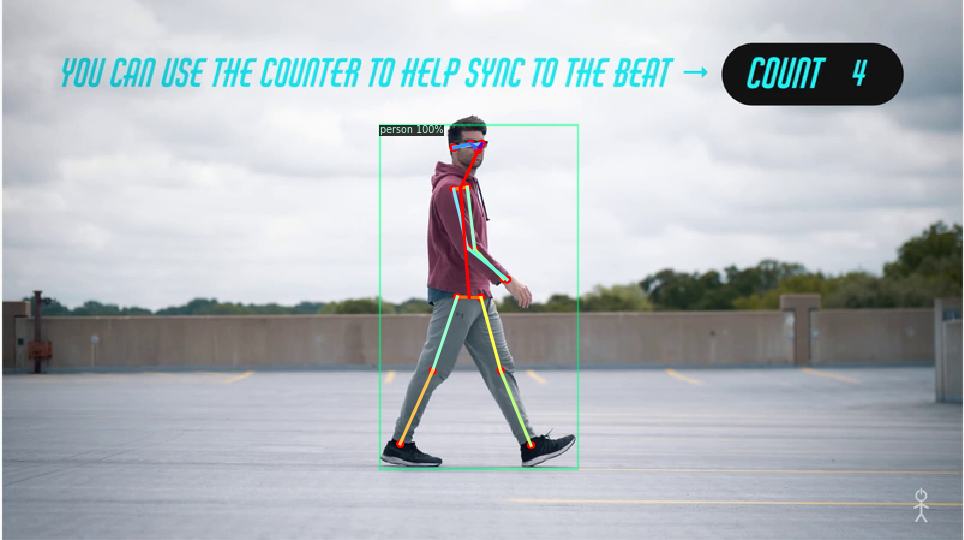

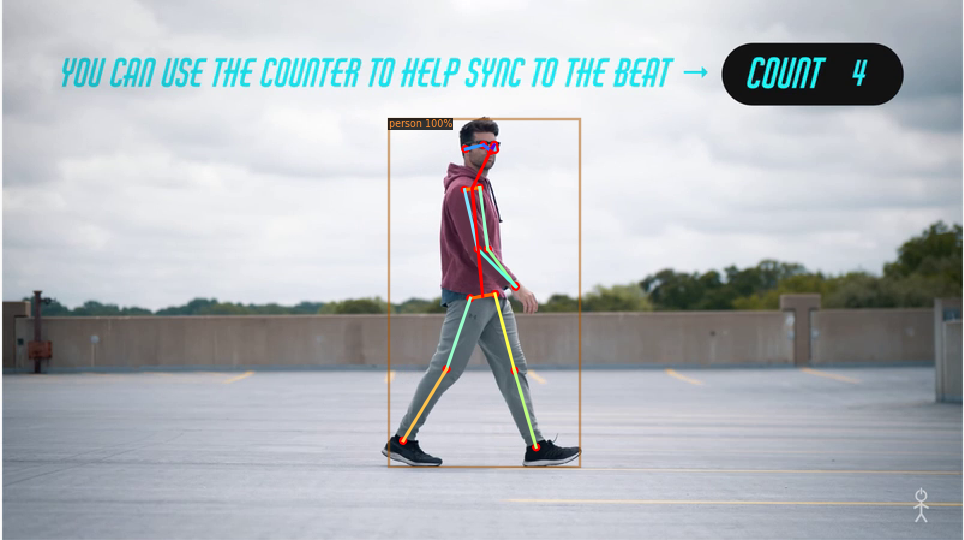

In [ ]:

input_sound_file = 'example_sound.wav'
# Open the wave file
wf = wave.open( input_sound_file, 'rb')

# Read wave file properties
RATE        = wf.getframerate()
WIDTH       = wf.getsampwidth()
LEN         = wf.getnframes()
CHANNELS    = wf.getnchannels()

# 
BLOCKLEN = int(0.5 * RATE)

# read from microphone
# p = pyaudio.PyAudio()
# stream = p.open(
#     format      = pyaudio.paInt16,
#     channels    = 1,
#     rate        = RATE,
#     input       = True,
#     output      = False
# )
MAXVALUE = 2**15-1 
threshold = MAXVALUE // 5
frames_left = LEN
weight = 2

while frames_left:
    
    read_len = BLOCKLEN if frames_left >= BLOCKLEN else frames_left
    
    input_bytes = wf.readframes(read_len)
    input_block = struct.unpack("h" * read_len, input_bytes)

    loud_frames = sum([weight if abs(input_block[i]) >= threshold else 0 for i in range(read_len) ])
    
    something_happened = loud_frames > (read_len / 10)
    
    if(something_happened):
        print("sus")
        monitorVideoStream(predictor)

    frames_left -= read_len



